In [6]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Normal

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_width, max_action):
        super(Actor, self).__init__()
        self.max_action = max_action
        self.layer1 = nn.Linear(state_dim, hidden_width)
        self.layer2 = nn.Linear(hidden_width, hidden_width)
        self.layer3 = nn.Linear(hidden_width, action_dim)

    def forward(self, state):
        x = F.relu(self.layer1(state))
        x = F.relu(self.layer2(x))
        action = self.max_action * torch.tanh(self.layer3(x))  # Scale output to action space bounds
        return action

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_width):
        super(Critic, self).__init__()
        self.layer1 = nn.Linear(state_dim + action_dim, hidden_width)
        self.layer2 = nn.Linear(hidden_width, hidden_width)
        self.layer3 = nn.Linear(hidden_width, 1)

    def forward(self, state, action):
        x = F.relu(self.layer1(torch.cat([state, action], 1)))
        x = F.relu(self.layer2(x))
        q_value = self.layer3(x)
        return q_value


In [8]:
class MemoryBuffer(object):
    def __init__(self, state_dim, action_dim):
        self.max_size = int(1e6)
        self.count = 0
        self.size = 0
        self.states = np.zeros((self.max_size, state_dim))
        self.actions = np.zeros((self.max_size, action_dim))
        self.rewards = np.zeros((self.max_size, 1))
        self.next_states = np.zeros((self.max_size, state_dim))
        self.dones = np.zeros((self.max_size, 1))

    def store(self, state, action, reward, next_state, done):
        self.states[self.count] = np.array(state)
        self.actions[self.count] = np.array(action)
        self.rewards[self.count] = np.array(reward)
        self.next_states[self.count] = np.array(next_state)
        self.dones[self.count] = np.array(done)
        self.count = (self.count + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        index = np.random.choice(self.size, size=batch_size)
        batch_states = torch.tensor(self.states[index], dtype=torch.float)
        batch_actions = torch.tensor(self.actions[index], dtype=torch.float)
        batch_rewards = torch.tensor(self.rewards[index], dtype=torch.float)
        batch_next_states = torch.tensor(self.next_states[index], dtype=torch.float)
        batch_dones = torch.tensor(self.dones[index], dtype=torch.float)
        return batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones


In [9]:
import numpy as np
import gym

# Hyperparameters
LEARNING_RATE = 1e-3  # Learning rate for the neural network optimizer
GAMMA = 0.99  # Discount factor
TAU = 0.005  # Soft update parameter
HIDDEN_WIDTH = 128  # Width of hidden layers in neural networks
BATCH_SIZE = 128  # Batch size for training
MAX_TRAIN_STEPS = 2000  # Maximum training steps
RANDOM_STEPS = 500  # Number of initial random steps for experience collection
UPDATE_FREQ = 50  # Frequency of training updates
EVALUATE_FREQ = 50  # Frequency of policy evaluation
NUM_EVALUATIONS = 50  # Number of evaluations

env_name = 'MountainCarContinuous-v0'
env = gym.make(env_name)
env_eval = gym.make(env_name)

state_dim = env.observation_space.shape[0]  # Dimensionality of the state space
action_dim = env.action_space.shape[0]  # Dimensionality of the action space
max_action = float(env.action_space.high[0])  # Maximum action value


In [10]:
import copy

class DDPG(object):
    def __init__(self, state_dim, action_dim, max_action):
        self.hidden_width = HIDDEN_WIDTH
        self.batch_size = BATCH_SIZE
        self.gamma = GAMMA
        self.tau = TAU
        self.lr = LEARNING_RATE

        self.actor = Actor(state_dim, action_dim, self.hidden_width, max_action)
        self.actor_target = copy.deepcopy(self.actor)
        self.critic = Critic(state_dim, action_dim, self.hidden_width)
        self.critic_target = copy.deepcopy(self.critic)

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=self.lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=self.lr)

        self.mse_loss = nn.MSELoss()

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
        action = self.actor(state).detach().numpy().flatten()
        return action

    def learn(self, memory_buffer):
        batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = memory_buffer.sample(self.batch_size)

        with torch.no_grad():
            next_actions = self.actor_target(batch_next_states)
            target_q = self.critic_target(batch_next_states, next_actions)
            target_q = batch_rewards + self.gamma * (1 - batch_dones) * target_q

        current_q = self.critic(batch_states, batch_actions)
        critic_loss = self.mse_loss(current_q, target_q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        for param in self.critic.parameters():
            param.requires_grad = False

        actor_loss = -self.critic(batch_states, self.actor(batch_states)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        for param in self.critic.parameters():
            param.requires_grad = True

        self.soft_update()

    def soft_update(self):
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


Evaluation #1 - Reward: -991
Evaluation #2 - Reward: -997
Evaluation #3 - Reward: -999
Evaluation #4 - Reward: -999
Evaluation #5 - Reward: -999
Evaluation #6 - Reward: -999
Evaluation #7 - Reward: -998
Evaluation #8 - Reward: -995
Evaluation #9 - Reward: -989
Evaluation #10 - Reward: -970
Evaluation #11 - Reward: -174
Evaluation #12 - Reward: -49
Evaluation #13 - Reward: -14
Evaluation #14 - Reward: -2
Evaluation #15 - Reward: 59
Evaluation #16 - Reward: 70
Evaluation #17 - Reward: 73
Evaluation #18 - Reward: 74
Evaluation #19 - Reward: 51
Evaluation #20 - Reward: 79
Evaluation #21 - Reward: 79
Evaluation #22 - Reward: 80
Evaluation #23 - Reward: 82
Evaluation #24 - Reward: 82
Evaluation #25 - Reward: 81
Evaluation #26 - Reward: 81
Evaluation #27 - Reward: 81
Evaluation #28 - Reward: 79
Evaluation #29 - Reward: 79
Evaluation #30 - Reward: 78
Evaluation #31 - Reward: 80
Evaluation #32 - Reward: 79
Evaluation #33 - Reward: 78
Evaluation #34 - Reward: 79
Evaluation #35 - Reward: 80
Evalu

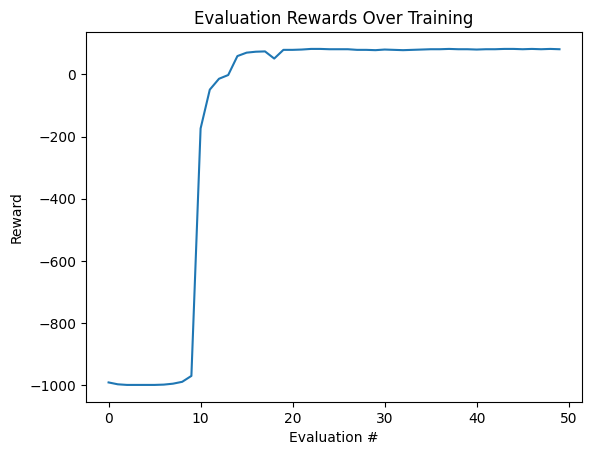

In [11]:
import matplotlib.pyplot as plt

def evaluate_policy(env, agent, max_steps=10000):
    times = 3
    evaluate_reward = 0
    for _ in range(times):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        step_count = 0
        while not done and step_count < max_steps:
            action = agent.choose_action(state)
            next_state, reward, done, _, _ = env.step(action)
            episode_reward += reward
            state = next_state
            step_count += 1
        
        evaluate_reward += episode_reward

    return int(evaluate_reward / times)

def train():
    agent = DDPG(state_dim, action_dim, max_action)
    memory_buffer = MemoryBuffer(state_dim, action_dim)

    noise_std = 0.1 * max_action
    evaluate_rewards = []
    total_steps = 0
    episode_count = 0

    while len(evaluate_rewards) < NUM_EVALUATIONS:  # Ensure evaluations run only 50 times
        state, _ = env.reset()
        episode_steps = 0
        done = False
        
        while not done:
            episode_steps += 1
            
            if total_steps < RANDOM_STEPS:
                action = env.action_space.sample()
            else:
                action = agent.choose_action(state)
                action += np.random.normal(0, noise_std, size=action_dim)
                action = np.clip(action, -max_action, max_action)
            
            next_state, reward, done, _, _ = env.step(action)
            reward = (reward + 1) / 2
            done_without_reaching_goal = True if done and episode_steps < env._max_episode_steps else False
            replay_buffer.store(state, action, reward, next_state, done_without_reaching_goal)
            state = next_state

            if total_steps >= RANDOM_STEPS and total_steps % UPDATE_FREQ == 0:
                for _ in range(UPDATE_FREQ):
                    agent.learn(replay_buffer)

            if total_steps >= RANDOM_STEPS and total_steps % EVALUATE_FREQ == 0 and len(evaluate_rewards) < NUM_EVALUATIONS:
                evaluate_reward = evaluate_policy(env_eval, agent)
                evaluate_rewards.append(evaluate_reward)
                print(f"Evaluation #{len(evaluate_rewards)} - Reward: {evaluate_reward}")

            total_steps += 1

        episode_count += 1

    env.close()
    print(f"Total Training Episodes: {episode_count}")

    # Plot the rewards
    plt.plot(evaluate_rewards)
    plt.xlabel('Evaluation #')
    plt.ylabel('Reward')
    plt.title('Evaluation Rewards Over Training')
    plt.show()

    return agent

# Train the agent
agent = train()


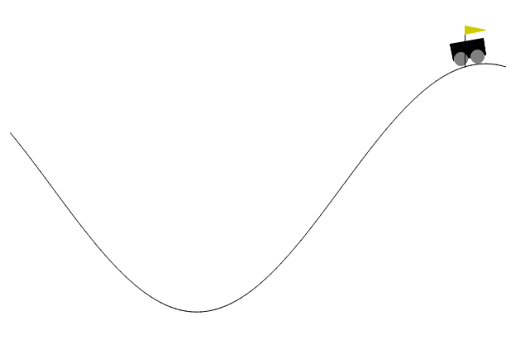

In [12]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def visualize_model(env, agent, render_mode='rgb_array', max_steps=1000, seed=42):
    state, info = env.reset(seed=seed)
    
    for episode in range(1):
        terminated = False
        truncated = False
        steps = 0
        
        while not (terminated or truncated) and steps < max_steps:
            # Choose an action using the DDPG agent
            action = agent.choose_action(state) 
            # Take the action and get the next state and reward
            new_state, reward, terminated, truncated, info = env.step(action)
            state = new_state
            
            # Render the environment if in rgb_array mode for animation
            if render_mode == 'rgb_array':
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.axis('off')
                plt.show()
                
            steps += 1
        
        # Reset the environment for the next episode
        state, info = env.reset()
    
    # Close the environment
    env.close()

# Use the same environment and agent that were used for training
env_visualization = gym.make(env_name, render_mode='rgb_array')
visualize_model(env_visualization, agent)
